In [414]:
import numpy as np
import pandas as pd
from typing import List, Optional
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

# Data Import

In [415]:
df = pd.read_csv('data/data.csv', delimiter=';')
df.head(10)

,instrument_oid,instrument_type,category,num_underlyings,expiry_date,time_to_expiry,num_paths,num_time_steps,num_exercise_events,calibration_date,calibration_time
0,27664617,Option,BRC,3,24.04.2025 17:30,0.898630,15000,1,0,31.05.2024,19.875000
1,26915220,TotalReturnSwap,AC,3,12.09.2024 00:00,0.284932,15000,1,2,31.05.2024,24.343750
2,27004793,Option,BRC,3,02.10.2024 17:30,0.339726,15000,1,0,31.05.2024,19.703125
3,27445282,Option,BRC,3,03.03.2025 17:35,0.756164,15000,1,0,31.05.2024,18.343750
4,27077768,Option,BRC,3,24.07.2024 17:30,0.147945,15000,1,0,31.05.2024,19.734375
5,27382039,Option,BRC,3,03.02.2025 17:30,0.679452,15000,1,0,31.05.2024,19.015625
6,26439765,Option,BRC,2,17.06.2024 17:30,0.046575,15000,1,0,31.05.2024,6.171875
7,27698642,Option,BRC,3,07.02.2025 17:30,0.690411,15000,1,0,31.05.2024,20.734375
8,27447413,Option,BRC,4,24.02.2025 17:30,0.736986,15000,1,0,31.05.2024,42.187500
9,27469085,TotalReturnSwap,AC,3,10.03.2025 00:00,0.775342,15000,1,4,31.05.2024,39.625000


In [416]:
def preprocess_data_frame(df: pd.DataFrame) -> None:
    """Inplace preprocessing of raw data frame"""
    columns_to_drop = [
        'instrument_oid',
        'instrument_type',
        'expiry_date',
        'num_time_steps',
        'calibration_date']
    df.drop(columns_to_drop, axis=1, inplace=True)
    label_encoder = LabelEncoder()
    df['category'] = label_encoder.fit_transform(df['category'])

feature_names = np.array([
    'category',
    'num_underlyings',
    'time_to_expiry',
    'num_paths',
    'num_exercise_events'])
preprocess_data_frame(df)    
df.head(10)

,category,num_underlyings,time_to_expiry,num_paths,num_exercise_events,calibration_time
0,2,3,0.898630,15000,0,19.875000
1,0,3,0.284932,15000,2,24.343750
2,2,3,0.339726,15000,0,19.703125
3,2,3,0.756164,15000,0,18.343750
4,2,3,0.147945,15000,0,19.734375
5,2,3,0.679452,15000,0,19.015625
6,2,2,0.046575,15000,0,6.171875
7,2,3,0.690411,15000,0,20.734375
8,2,4,0.736986,15000,0,42.187500
9,0,3,0.775342,15000,4,39.625000


In [417]:
def init_data_sets(
        df: pd.DataFrame,
        test_size: Optional[float] = 0.3) -> Tuple[np.ndarray, np.ndarray, np.array, np.array]:
    """Build training and test data set from data frame"""
    X = df.to_numpy()
    X, y = X[:, 0:-1], X[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    print(f'Split data frame with {df.shape} '
          f'rows into training data set of size {X_train.shape} '
          f'and test data set of size {X_test.shape} ... ')
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = init_data_sets(df)

Split data frame with (9087, 6) rows into training data set of size (6360, 5) and test data set of size (2727, 5) ... 


# Model Specification

In [420]:
def create_random_forest_regressor(max_depth: int, n_estimators: int) -> BaseEstimator:
    model = make_pipeline(
        StandardScaler(),
        RandomForestRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators))
    return model.fit(X_train, y_train)

# Hyperparameter Tuning

In [448]:
n_estimators = 500

max_depth_list = list(range(3, 16))
training_mse, training_score = list(), list()
test_mse, test_score = list(), list()
for max_depth in max_depth_list:
    print(f'Fitting models for max depth {max_depth} ... ')
    model = create_random_forest_regressor(max_depth, n_estimators)
    
    y_predict = model.predict(X_train)
    training_mse.append(mean_squared_error(y_predict, y_train))
    training_score.append(r2_score(y_predict, y_train))
    
    y_predict = model.predict(X_test)
    test_mse.append(mean_squared_error(y_predict, y_test))
    test_score.append(r2_score(y_predict, y_test))

Fitting models for max depth 3 ... 
Fitting models for max depth 4 ... 
Fitting models for max depth 5 ... 
Fitting models for max depth 6 ... 
Fitting models for max depth 7 ... 
Fitting models for max depth 8 ... 
Fitting models for max depth 9 ... 
Fitting models for max depth 10 ... 
Fitting models for max depth 11 ... 
Fitting models for max depth 12 ... 
Fitting models for max depth 13 ... 
Fitting models for max depth 14 ... 
Fitting models for max depth 15 ... 


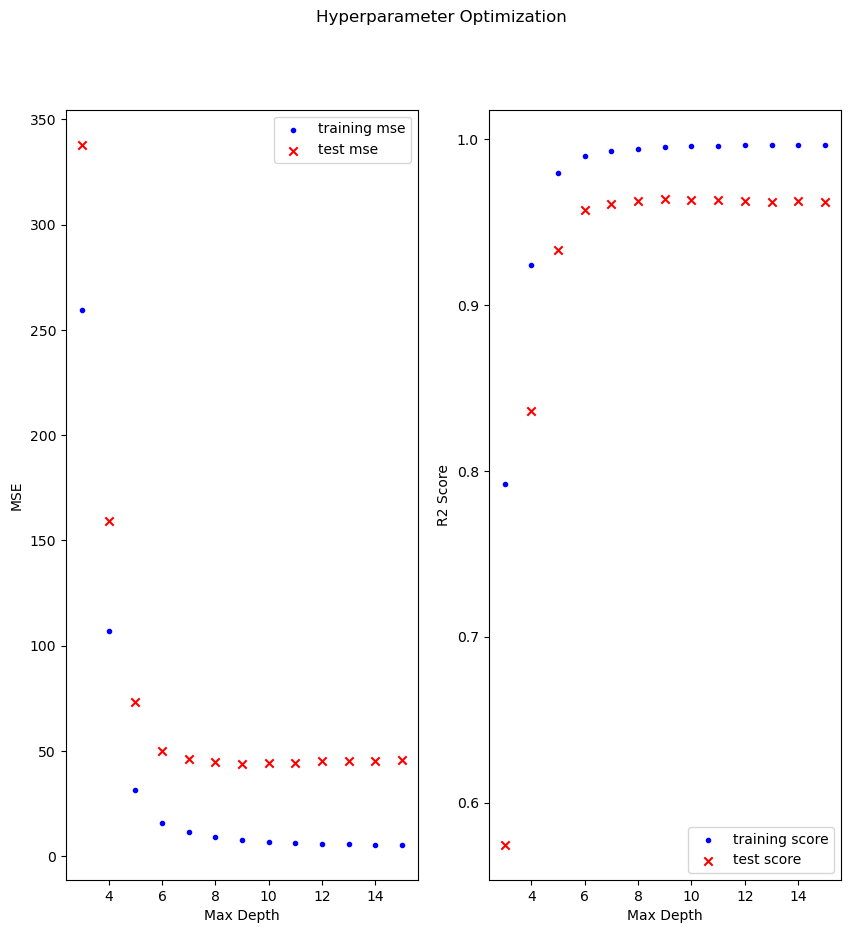

In [450]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
fig.suptitle('Hyperparameter Optimization')

ax1.scatter(
    max_depth_list,
    training_mse,
    c='b',
    marker='.',
    label='training mse')
ax1.scatter(
    max_depth_list,
    test_mse,
    c='r',
    marker='x',
    label='test mse')
ax1.legend()
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('MSE')

ax2.scatter(
    max_depth_list,
    training_score,
    c='b',
    marker='.',
    label='training score')
ax2.scatter(
    max_depth_list,
    test_score,
    c='r',
    marker='x',
    label='test score')
ax2.legend()
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('R2 Score')

plt.show()

In [451]:
max_depth = 8

n_estimators_list = list(range(25, 600, 25))
training_mse, training_score = list(), list()
test_mse, test_score = list(), list()
for n_estimators in n_estimators_list:
    print(f'Fitting models for n_estimators {n_estimators} ... ')
    model = create_random_forest_regressor(max_depth, n_estimators)
    
    y_predict = model.predict(X_train)
    training_mse.append(mean_squared_error(y_predict, y_train))
    training_score.append(r2_score(y_predict, y_train))
    
    y_predict = model.predict(X_test)
    test_mse.append(mean_squared_error(y_predict, y_test))
    test_score.append(r2_score(y_predict, y_test))

Fitting models for n_estimators 25 ... 
Fitting models for n_estimators 50 ... 
Fitting models for n_estimators 75 ... 
Fitting models for n_estimators 100 ... 
Fitting models for n_estimators 125 ... 
Fitting models for n_estimators 150 ... 
Fitting models for n_estimators 175 ... 
Fitting models for n_estimators 200 ... 
Fitting models for n_estimators 225 ... 
Fitting models for n_estimators 250 ... 
Fitting models for n_estimators 275 ... 
Fitting models for n_estimators 300 ... 
Fitting models for n_estimators 325 ... 
Fitting models for n_estimators 350 ... 
Fitting models for n_estimators 375 ... 
Fitting models for n_estimators 400 ... 
Fitting models for n_estimators 425 ... 
Fitting models for n_estimators 450 ... 
Fitting models for n_estimators 475 ... 
Fitting models for n_estimators 500 ... 
Fitting models for n_estimators 525 ... 
Fitting models for n_estimators 550 ... 
Fitting models for n_estimators 575 ... 


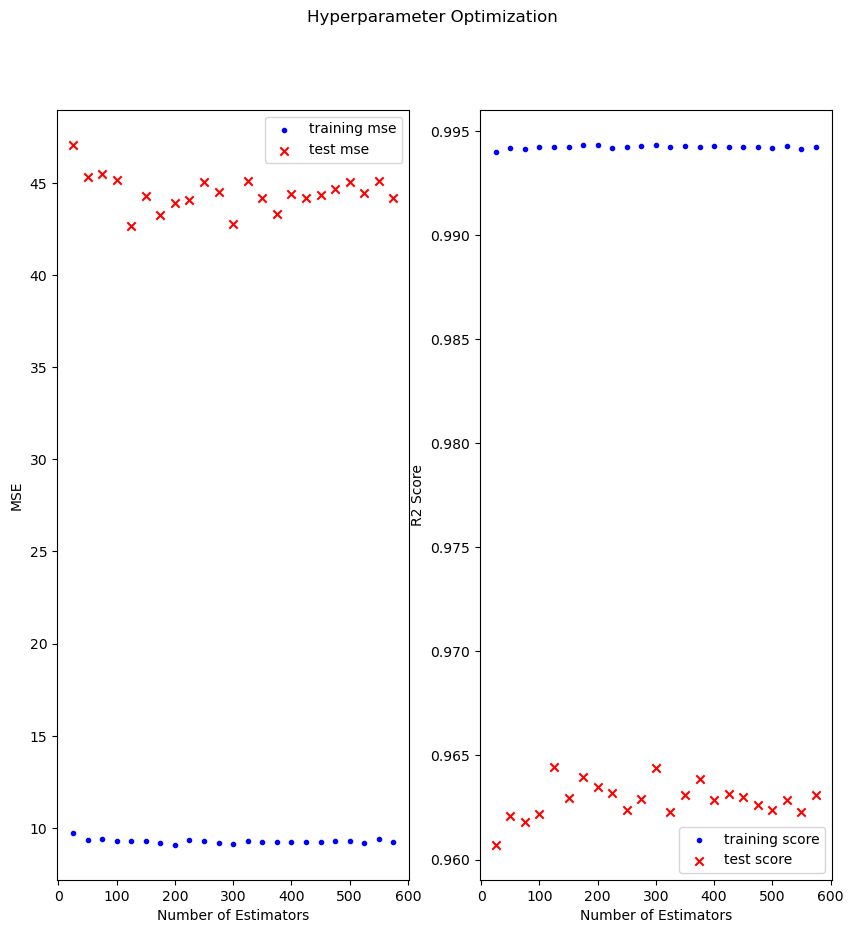

In [453]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
fig.suptitle('Hyperparameter Optimization')

ax1.scatter(
    n_estimators_list,
    training_mse,
    c='b',
    marker='.',
    label='training mse')
ax1.scatter(
    n_estimators_list,
    test_mse,
    c='r',
    marker='x',
    label='test mse')
ax1.legend()
ax1.set_xlabel('Number of Estimators')
ax1.set_ylabel('MSE')

ax2.scatter(
    n_estimators_list,
    training_score,
    c='b',
    marker='.',
    label='training score')
ax2.scatter(
    n_estimators_list,
    test_score,
    c='r',
    marker='x',
    label='test score')
ax2.legend()
ax2.set_xlabel('Number of Estimators')
ax2.set_ylabel('R2 Score')

plt.show()

In [456]:
model = create_random_forest_regressor(8, 300)

y_predict = model.predict(X_train)
training_mse = mean_squared_error(y_predict, y_train)
training_score = r2_score(y_predict, y_train)

y_predict = model.predict(X_test)
test_mse = mean_squared_error(y_predict, y_test) 
test_score = r2_score(y_predict, y_test)

print(f'Best model: ' 
      f'training mse={training_error:.4f}, '
      f'training score={training_score:.4f}, '
      f'test mse={test_error:.4f}, '
      f'test score={test_score:.4f}')

Best model: training mse=5.2745, training score=0.9943, test mse=44.8724, test score=0.9637


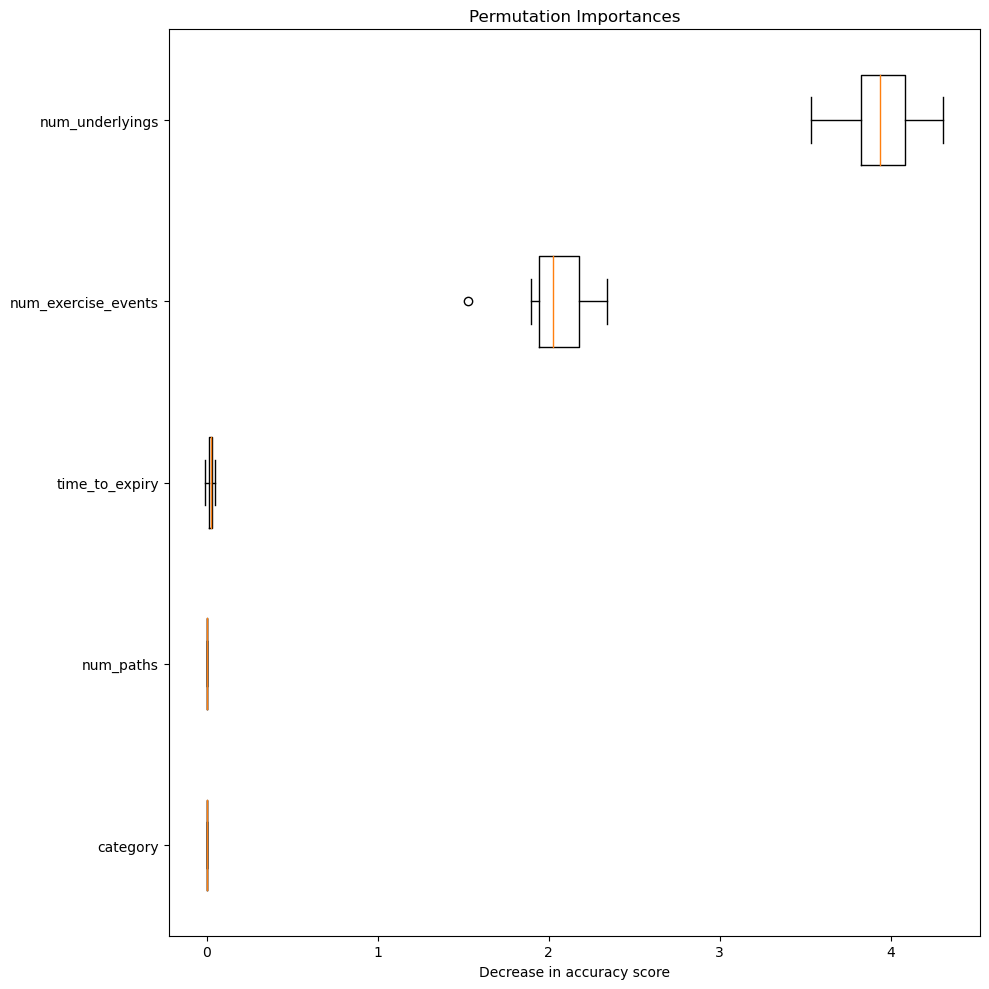

In [459]:
def plot_perm_importance(model, sorted_idx, feature_names):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.boxplot(
        model.importances[sorted_idx].T,
        vert=False,
        labels=feature_names[sorted_idx])
    ax.set_title(f'Permutation Importances')
    ax.set_xlabel('Decrease in accuracy score')
    fig.tight_layout()
    plt.show()
    
result = permutation_importance(
    estimator=model[1],
    X=X_test,
    y=y_test,
    n_repeats=10,
    n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plot_perm_importance(result, sorted_idx, feature_names)